# Real-Time Fraud Detection using Unsupervised Learning

## Objective
Detect fraudulent credit card transactions using:
- Isolation Forest
- Local Outlier Factor (LOF)

Dataset contains extreme class imbalance (<0.2% fraud).


In [3]:
!pip install scikit-learn seaborn matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 3.9 MB/s  0:00:02 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 8.9 MB/s  0:00:02 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [scikit-learn] [scikit-learn]


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings("ignore")


In [2]:
df = pd.read_csv("creditcard.csv")
df.shape


(284807, 31)

In [3]:
df['Class'].value_counts()


Class
0    284315
1       492
Name: count, dtype: int64

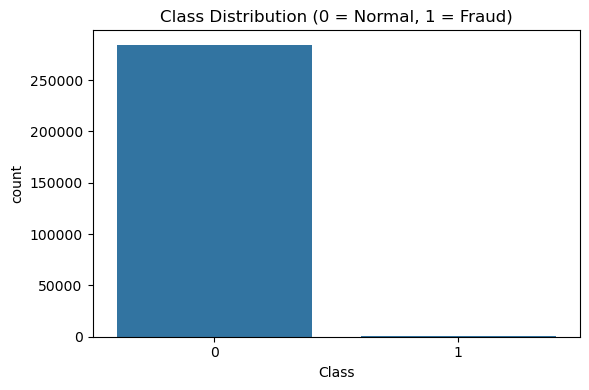

In [14]:
plt.figure(figsize=(6,4))
sns.countplot(x='Class', data=df)
plt.title("Class Distribution (0 = Normal, 1 = Fraud)")
plt.tight_layout()

plt.savefig("images/class_distribution.png", dpi=300)
plt.show()


In [5]:
from sklearn.preprocessing import RobustScaler

rs = RobustScaler()

df['scaled_amount'] = rs.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rs.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Amount','Time'], axis=1, inplace=True)

df.head()


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,scaled_amount,scaled_time
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,1.783274,-0.994983
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.269825,-0.994983
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,4.983721,-0.994972
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,1.418291,-0.994972
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,0.670579,-0.994960


In [6]:
X = df.drop('Class', axis=1)
y = df['Class']

print(X.shape)



(284807, 30)


In [7]:
from sklearn.ensemble import IsolationForest

iso = IsolationForest(
    n_estimators=100,
    contamination=0.001,   # expected fraud ratio (~0.1%)
    random_state=42,
    n_jobs=-1
)

y_pred_iso = iso.fit_predict(X)

# Convert output: (-1 = anomaly, 1 = normal)
y_pred_iso = np.where(y_pred_iso == -1, 1, 0)


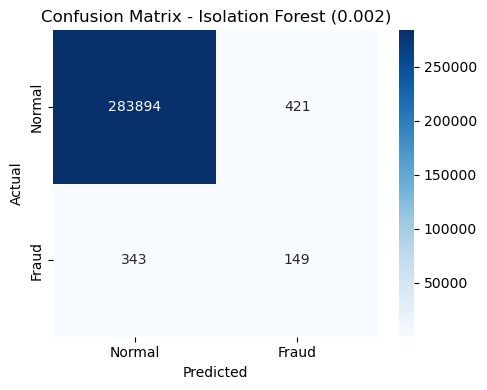

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y, y_pred_iso2)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Fraud'],
            yticklabels=['Normal', 'Fraud'])

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Isolation Forest (0.002)")
plt.tight_layout()

plt.savefig("images/confusion_matrix.png", dpi=300)
plt.show()


In [9]:
iso2 = IsolationForest(
    n_estimators=100,
    contamination=0.002,   # slightly higher
    random_state=42,
    n_jobs=-1
)

y_pred_iso2 = iso2.fit_predict(X)
y_pred_iso2 = np.where(y_pred_iso2 == -1, 1, 0)

print(confusion_matrix(y, y_pred_iso2))
print(classification_report(y, y_pred_iso2))


[[283894    421]
 [   343    149]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    284315
           1       0.26      0.30      0.28       492

    accuracy                           1.00    284807
   macro avg       0.63      0.65      0.64    284807
weighted avg       1.00      1.00      1.00    284807



In [10]:
from sklearn.metrics import precision_score, recall_score, f1_score

def evaluate_model(name, y_true, y_pred):
    print(f"----- {name} -----")
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall:", recall_score(y_true, y_pred))
    print("F1 Score:", f1_score(y_true, y_pred))
    print()
    
evaluate_model("Isolation Forest (0.001)", y, y_pred_iso)
evaluate_model("Isolation Forest (0.002)", y, y_pred_iso2)


----- Isolation Forest (0.001) -----
Precision: 0.3649122807017544
Recall: 0.21138211382113822
F1 Score: 0.2676962676962677

----- Isolation Forest (0.002) -----
Precision: 0.2614035087719298
Recall: 0.30284552845528456
F1 Score: 0.2806026365348399



In [11]:
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor(
    n_neighbors=20,
    contamination=0.002,
    n_jobs=-1
)

y_pred_lof = lof.fit_predict(X)
y_pred_lof = np.where(y_pred_lof == -1, 1, 0)

print(confusion_matrix(y, y_pred_lof))
print(classification_report(y, y_pred_lof))


[[283745    570]
 [   492      0]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    284315
           1       0.00      0.00      0.00       492

    accuracy                           1.00    284807
   macro avg       0.50      0.50      0.50    284807
weighted avg       1.00      1.00      1.00    284807



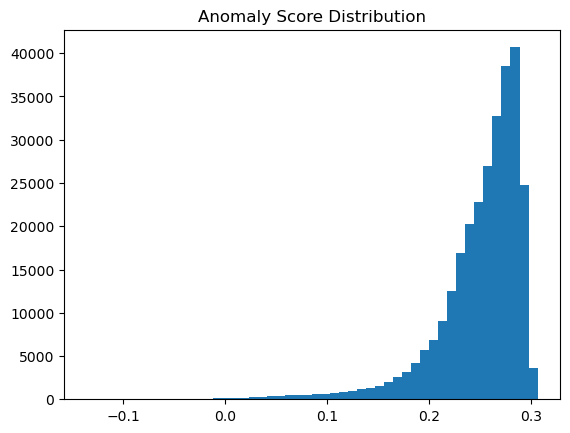

In [12]:
scores = iso2.decision_function(X)

import matplotlib.pyplot as plt
plt.hist(scores, bins=50)
plt.title("Anomaly Score Distribution")
plt.show()


In [13]:
import numpy as np

# Let's try a stricter threshold (1% lowest scores)
threshold = np.percentile(scores, 1)

y_custom = (scores < threshold).astype(int)

from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(y, y_custom))
print(classification_report(y, y_custom))


[[281746   2569]
 [   212    280]]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00    284315
           1       0.10      0.57      0.17       492

    accuracy                           0.99    284807
   macro avg       0.55      0.78      0.58    284807
weighted avg       1.00      0.99      0.99    284807



## Final Model Recommendation

Isolation Forest with contamination = 0.002 was selected as the optimal model. It achieved a recall of ~30% while maintaining reasonable precision, demonstrating better scalability and stability compared to LOF.

Manual threshold tuning showed recall can be increased to 57%, highlighting the tradeoff between fraud detection rate and false positives.
